<IMG SRC="https://avatars2.githubusercontent.com/u/31697400?s=400&u=a5a6fc31ec93c07853dd53835936fd90c44f7483&v=4" WIDTH=125 ALIGN="right">

    
# Local grid refinement   

*O.N. Ebbens, Artesia, 2022*

This notebook shows an example of a vertex model create with the `nlmod` package.

### Contents<a name="TOC"></a>
1. [Create model](#create)
2. [Local grid refinement](#lgr)
3. [Run Model](#run)
3. [Visualise](#Visualise)

In [1]:
import matplotlib.pyplot as plt
import flopy
import os
import geopandas as gpd
import logging

import nlmod

In [2]:
print(f'nlmod version: {nlmod.__version__}')

# toon informatie bij het aanroepen van functies
logging.basicConfig(level=logging.INFO)

nlmod version: 0.2.5b


### [1. Create model](#TOC)<a name="create"></a>

Modflow 6 makes it possible to use locally refined grids. In NLmod you can use a shapefile and a number of levels to specify where and how much you want to use local grid refinement. Below we use a shapefile of the Planetenweg in IJmuiden and set the refinement levels at 2. This well create a grid with cells of 100x100m except at the Planetenweg where the cells will be refined to 25x25m. See also figures below.

In [3]:
# model settings vertex
model_ws = 'model3'
model_name = 'IJm_planeten'
figdir, cachedir = nlmod.util.get_model_dirs(model_ws)
refine_shp_fname = os.path.join(
    nlmod.NLMOD_DATADIR, 'shapes', 'planetenweg_ijmuiden')
levels = 2
extent = [95000., 105000., 494000., 500000.]
delr = 100.
delc = 100.
steady_state = False
steady_start = True
transient_timesteps = 5
perlen = 1.
start_time = '2015-1-1'
gridtype = 'vertex'
use_regis = True
regis_botm_layer = 'MSz1'
use_geotop = True
add_northsea = True
starting_head = 1.0

In [4]:
layer_model = nlmod.read.regis.get_combined_layer_models(extent,
                                                         use_regis=use_regis,
                                                         regis_botm_layer=regis_botm_layer,
                                                         use_geotop=use_geotop,
                                                         cachedir=cachedir,
                                                         cachename='combined_layer_ds.nc')

# create a model ds by changing grid of layer_model
model_ds = nlmod.read.regis.to_model_ds(layer_model, model_name, model_ws, delr=delr, delc=delc)

# add time discretisation
model_ds = nlmod.mdims.set_model_ds_time(model_ds,
                                         start_time=start_time,
                                         steady_state=steady_state,
                                         steady_start=steady_start,
                                         transient_timesteps=transient_timesteps,
                                         perlen=perlen)


INFO:nlmod.cache:using cached data -> combined_layer_ds.nc
INFO:nlmod.read.regis:resample regis data to structured modelgrid
INFO:nlmod.mdims.mlayers:get first active modellayer for each cell in idomain


### [2. Local grid refinement](#TOC)<a name="lgr"></a>

the code below applies a local grid refinement to the layer model. The local grid refinement is based on the shapefile 'planetenweg_ijmuiden.shp', which contains a line shape of the Planetenweg, and the levels, which is 2. This means that the model cells at the Planetenweg will get a size of 25 x 25m. 

In [5]:
# use gridgen to create vertex grid
model_ds = nlmod.mgrid.refine(model_ds, refinement_features=[(refine_shp_fname, 'line', levels)])

if add_northsea:
    model_ds = nlmod.mdims.add_northsea(model_ds)

INFO:nlmod.mdims.mgrid:create vertex grid using gridgen
INFO:nlmod.mdims.resample:resample model layer data to vertex modelgrid
INFO:nlmod.mdims.mlayers:get first active modellayer for each cell in idomain
INFO:nlmod.mdims.mlayers:nan values at the northsea are filled using the bathymetry from jarkus
C:\Users\oebbe\anaconda3\envs\nlmod\lib\site-packages\flopy\utils\gridintersect.py:138: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  self.strtree = STRtree(self._get_gridshapes())
C:\Users\oebbe\anaconda3\envs\nlmod\lib\site-packages\flopy\utils\gridintersect.py:293: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = icell
INFO:nlmod.mdims.mlayers:get first active modellayer for each cell in idomain


In [6]:
# create simulation 
sim = nlmod.gwf.sim_from_model_ds(model_ds)

# create time discretisation
tdis = nlmod.gwf.tdis_from_model_ds(model_ds, sim)

# create groundwater flow model
gwf = nlmod.gwf.gwf_from_model_ds(model_ds, sim)

# create ims
ims = nlmod.gwf.ims_to_sim(sim)

# Create discretization
disv = nlmod.gwf.disv_from_model_ds(model_ds, gwf)

INFO:nlmod.gwf.sim:creating modflow SIM
INFO:nlmod.gwf.sim:creating modflow SIM, TDIS, GWF and IMS
INFO:nlmod.gwf.gwf:creating modflow GWF
INFO:nlmod.gwf.gwf:creating modflow IMS


In [7]:
# create node property flow
npf = nlmod.gwf.npf_from_model_ds(model_ds, gwf, save_flows=True)

# Create the initial conditions package
ic = nlmod.gwf.ic_from_model_ds(model_ds, gwf, starting_head=starting_head)

# Create the output control package
oc = nlmod.gwf.oc_from_model_ds(model_ds, gwf)

In [8]:
# voeg grote oppervlaktewaterlichamen toe
da_name = 'rws_oppwater'
rws_ds = nlmod.read.rws.get_surface_water(model_ds,
                                          da_name,
                                          cachedir=model_ds.cachedir,
                                          cachename=da_name+'.nc')
model_ds.update(rws_ds)
ghb = nlmod.gwf.ghb_from_model_ds(model_ds, gwf, da_name)

# surface level drain
ahn_ds = nlmod.read.ahn.get_ahn(model_ds,
                                cachedir=model_ds.cachedir,
                                cachename='ahn.nc')
model_ds.update(ahn_ds)

drn = nlmod.gwf.surface_drain_from_model_ds(model_ds, gwf)


# add constant head cells at model boundaries
model_ds.update(nlmod.gwf.constant_head.get_chd_at_model_edge(model_ds, model_ds['idomain']))    
chd = nlmod.gwf.chd_from_model_ds(model_ds, gwf, head='starting_head')

INFO:nlmod.cache:coordinate x has different values in cached dataset, not using cache
C:\Users\oebbe\anaconda3\envs\nlmod\lib\site-packages\flopy\utils\gridintersect.py:138: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  self.strtree = STRtree(self._get_gridshapes())
C:\Users\oebbe\anaconda3\envs\nlmod\lib\site-packages\flopy\utils\gridintersect.py:293: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = icell
C:\Users\oebbe\anaconda3\envs\nlmod\lib\site-packages\numpy\core\records.py:506: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  return self.setfield(val, *res)
INFO:nlmod.cache:caching data -> rws_oppwater.nc
INFO:nlmod.cache:coordinate x has different values i

In [9]:
# add knmi recharge to the model datasets
knmi_ds = nlmod.read.knmi.get_recharge(model_ds, cachedir=model_ds.cachedir, cachename='recharge')
model_ds.update(knmi_ds)

# create recharge package
rch = nlmod.gwf.rch_from_model_ds(model_ds, gwf)

INFO:nlmod.cache:coordinate x has different values in cached dataset, not using cache
INFO:hydropandas.io.io_knmi:download knmi RD data from station 225-OVERVEEN between 2005-01-01 00:00:00 and 2015-01-07 00:00:00
INFO:hydropandas.io.io_knmi:station 225 has 0 missing measurements
INFO:hydropandas.io.io_knmi:download knmi RD data from station 226-WIJK-AAN-ZEE between 2005-01-01 00:00:00 and 2015-01-07 00:00:00
INFO:hydropandas.io.io_knmi:station 226 has 0 missing measurements
INFO:hydropandas.io.io_knmi:download knmi RD data from station 263-ASSENDELFT between 2005-01-01 00:00:00 and 2015-01-07 00:00:00
INFO:hydropandas.io.io_knmi:station 263 has no measurements before 2006-03-08 09:00:00
INFO:hydropandas.io.io_knmi:station 263 has 431 missing measurements
INFO:hydropandas.io.io_knmi:trying to fill 431 measurements with station [230]
INFO:hydropandas.io.io_knmi:download knmi RD data from station 230-ZAANDIJK between 2005-01-01 00:00:00 and 2015-01-07 00:00:00
INFO:hydropandas.io.io_knmi

In [10]:
model_ds

<xarray.Dataset>
Dimensions:             (layer: 40, icell2d: 6231, time: 6, iv: 6459, nvert: 7)
Coordinates:
  * layer               (layer) object 'AAOP' 'NASC' 'ONAWA' ... 'PZWAz4' 'MSz1'
  * time                (time) datetime64[ns] 2015-01-01 ... 2015-01-06
    x                   (icell2d) float64 9.505e+04 9.515e+04 ... 1.05e+05
    y                   (icell2d) float64 5e+05 5e+05 ... 4.94e+05 4.94e+05
Dimensions without coordinates: icell2d, iv, nvert
Data variables: (12/21)
    top                 (icell2d) float64 -19.0 -18.51 -18.51 ... 1.49 0.5 0.37
    botm                (layer, icell2d) float64 -19.0 -18.51 ... -218.2 -218.5
    kh                  (layer, icell2d) float64 1.0 1.0 1.0 ... 6.1 6.11 6.11
    kv                  (layer, icell2d) float64 0.1 0.1 0.1 ... 0.611 0.611
    idomain             (layer, icell2d) int32 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1
    first_active_layer  (icell2d) int32 8 8 8 8 8 8 8 8 8 ... 0 0 0 0 0 0 0 0 0
    ...                  ...
    rws_oppwater_cond   (icell2d) float64 1e+03 1e+03 1e+03 ... 0.0 0.0 0.0
    rws_oppwater_peil   (icell2d) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ahn                 (icell2d) float32 nan nan nan nan ... nan 0.782 0.224
    chd                 (layer, icell2d) int32 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1
    recharge            (icell2d, time) float64 -0.0004 0.0019 ... -0.0001
    rch_name            (icell2d) <U13 'rch_1' 'rch_1' ... 'rch_2' 'rch_2'
Attributes: (12/13)
    gridtype:                  vertex
    extent:                    [ 95000. 105000. 494000. 500000.]
    delr:                      100.0
    delc:                      100.0
    model_name:                IJm_planeten
    mfversion:                 mf6
    ...                        ...
    exe_name:                  c:\users\oebbe\02_python\nlmod\nlmod\mdims\..\...
    model_ws:                  model3
    figdir:                    model3\figure
    cachedir:                  model3\cache
    nodata:                    -999
    surface_drn_cond:          1000

### [3. Write and Run](#TOC)<a name="run"></a>


In [11]:
nlmod.gwf.write_and_run_model(gwf, model_ds, write_model_ds=True, nb_path='03_local_grid_refinement.ipynb')

INFO:nlmod.gwf.gwf:write script 2022082503_local_grid_refinement.ipynb to model workspace
INFO:nlmod.gwf.gwf:write model dataset to cache
INFO:nlmod.gwf.gwf:write modflow files to model workspace


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model IJm_planeten...
    writing model name file...
    writing package disv...
    writing package npf...
    writing package ic...
    writing package oc...
    writing package ghb_0...
    writing package drn_0...
    writing package chd...
    writing package rch...


INFO:nlmod.gwf.gwf:run model


    writing package ts_0...
    writing package ts_1...
    writing package ts_2...
FloPy is using the following  executable to run the model: c:\users\oebbe\02_python\nlmod\nlmod\gwf\..\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/04/2022

   MODFLOW 6 compiled Mar 07 2022 16:14:29 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute 

### [4. Visualise](#TOC)<a name="visualise"></a>

Using the `model_ds` and `gwf` variables it is quite easy to visualise model data. Below the modelgrid together with the surface water is shown.

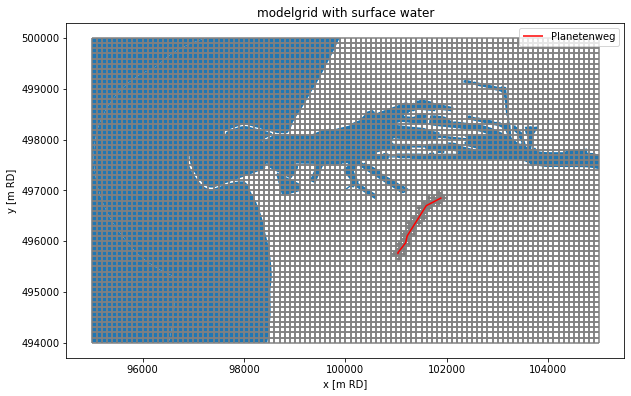

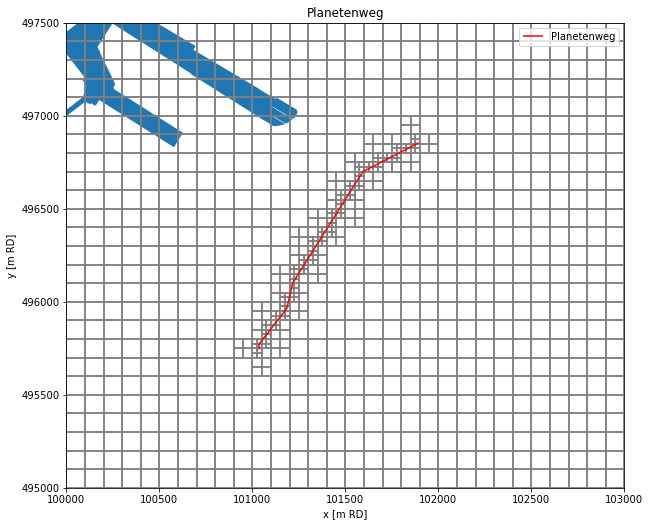

In [12]:
plan_weg_gdf = gpd.read_file(refine_shp_fname+'.shp')

# plot modelgrid
ax = nlmod.visualise.plots.plot_modelgrid(model_ds, gwf)
plan_weg_gdf.plot(ax=ax, color='r', label='Planetenweg')
ax.legend()
ax.get_figure().savefig(os.path.join(model_ds.figdir, 'mgrid_swater.png'), bbox_inches='tight')

# plot zoomed modelgrid
ax = nlmod.visualise.plots.plot_modelgrid(model_ds, gwf)
ax.set_title('Planetenweg')
plan_weg_gdf.plot(ax=ax, color='r', label='Planetenweg')
ax.set_xlim(100000, 103000)
ax.set_ylim(495000, 497500)
ax.legend()
ax.get_figure().savefig(os.path.join(model_ds.figdir, 'Planetenweg.png'), bbox_inches='tight')

The model dataset of a vertex model differs from a structured model dataset. The data is stored relative to the cell-id instead of the row and column number. Therefore the model dataset has the dimension icell2d instead of the dimensions x and y. 

In [13]:
model_ds

<xarray.Dataset>
Dimensions:             (layer: 40, icell2d: 6231, time: 6, iv: 6459, nvert: 7)
Coordinates:
  * layer               (layer) object 'AAOP' 'NASC' 'ONAWA' ... 'PZWAz4' 'MSz1'
  * time                (time) datetime64[ns] 2015-01-01 ... 2015-01-06
    x                   (icell2d) float64 9.505e+04 9.515e+04 ... 1.05e+05
    y                   (icell2d) float64 5e+05 5e+05 ... 4.94e+05 4.94e+05
Dimensions without coordinates: icell2d, iv, nvert
Data variables: (12/21)
    top                 (icell2d) float64 -19.0 -18.51 -18.51 ... 1.49 0.5 0.37
    botm                (layer, icell2d) float64 -19.0 -18.51 ... -218.2 -218.5
    kh                  (layer, icell2d) float64 1.0 1.0 1.0 ... 6.1 6.11 6.11
    kv                  (layer, icell2d) float64 0.1 0.1 0.1 ... 0.611 0.611
    idomain             (layer, icell2d) int32 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1
    first_active_layer  (icell2d) int32 8 8 8 8 8 8 8 8 8 ... 0 0 0 0 0 0 0 0 0
    ...                  ...
    rws_oppwater_cond   (icell2d) float64 1e+03 1e+03 1e+03 ... 0.0 0.0 0.0
    rws_oppwater_peil   (icell2d) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ahn                 (icell2d) float32 nan nan nan nan ... nan 0.782 0.224
    chd                 (layer, icell2d) int32 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1
    recharge            (icell2d, time) float64 -0.0004 0.0019 ... -0.0001
    rch_name            (icell2d) <U13 'rch_1' 'rch_1' ... 'rch_2' 'rch_2'
Attributes: (12/16)
    gridtype:                          vertex
    extent:                            [ 95000. 105000. 494000. 500000.]
    delr:                              100.0
    delc:                              100.0
    model_name:                        IJm_planeten
    mfversion:                         mf6
    ...                                ...
    cachedir:                          model3\cache
    nodata:                            -999
    surface_drn_cond:                  1000
    model_dataset_written_to_disk_on:  20220825_16:43:43
    model_data_written_to_disk_on:     20220825_16:43:49
    model_ran_on:                      20220825_16:44:00

To plot the same rasters as for the previous model we can use the `nlmod.visualise.plots.plot_vertex_array()` function.

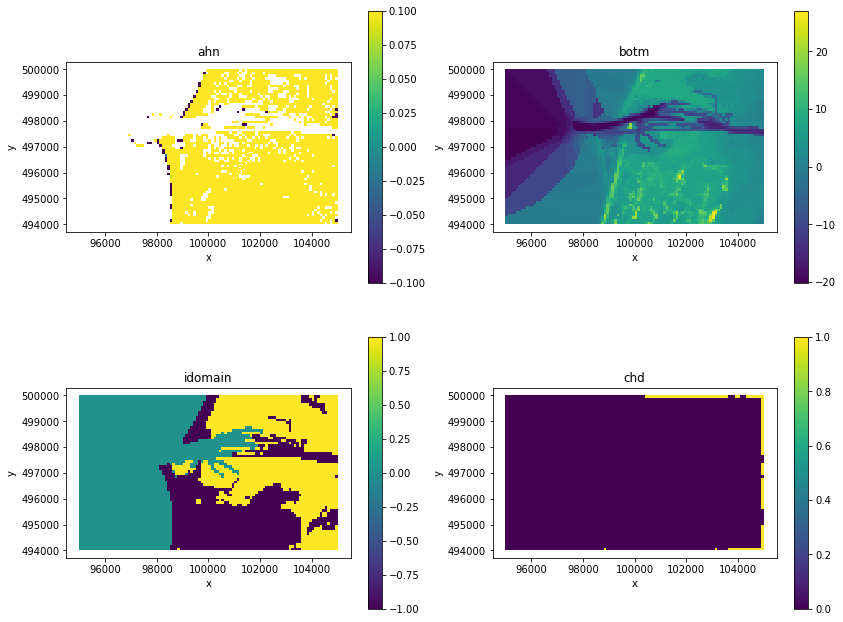

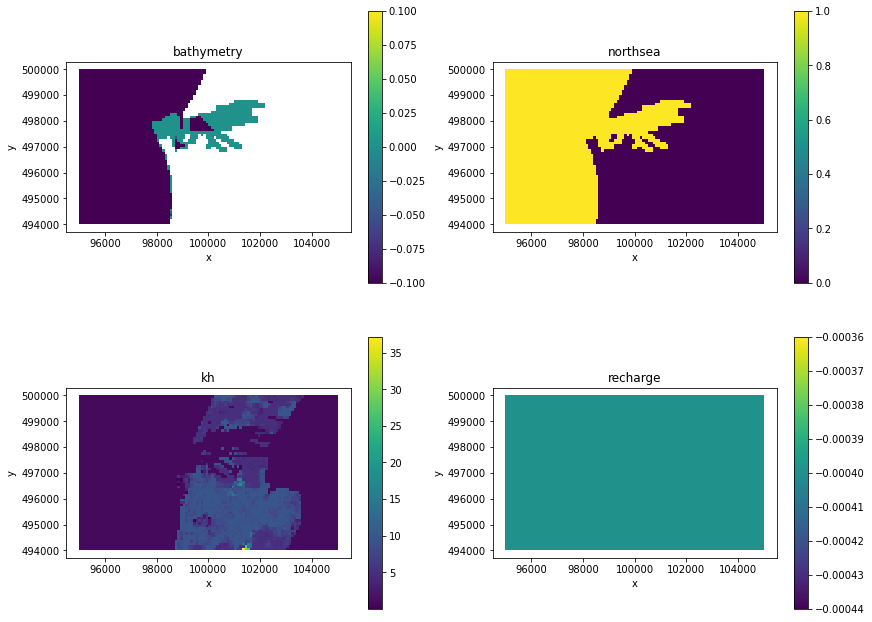

In [14]:
model_ds['vertices'] = nlmod.mdims.get_vertices(model_ds)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 11))
nlmod.visualise.plots.plot_vertex_array(model_ds['ahn'], model_ds['vertices'], ax=axes[0][0])
nlmod.visualise.plots.plot_vertex_array(model_ds['botm'][0], model_ds['vertices'], ax=axes[0][1])
nlmod.visualise.plots.plot_vertex_array(model_ds['idomain'][0], model_ds['vertices'], ax=axes[1][0])
nlmod.visualise.plots.plot_vertex_array(model_ds['chd'][0], model_ds['vertices'], ax=axes[1][1])
for axes1 in axes:
    for ax in axes1:
        ax.axis('scaled')

fig.savefig(os.path.join(model_ds.figdir, 'ahn_bot_idom_chd.png'), bbox_inches='tight')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 11))
nlmod.visualise.plots.plot_vertex_array(model_ds['bathymetry'], model_ds['vertices'], ax=axes[0][0])
nlmod.visualise.plots.plot_vertex_array(model_ds['northsea'], model_ds['vertices'], ax=axes[0][1])
nlmod.visualise.plots.plot_vertex_array(model_ds['kh'][1], model_ds['vertices'], ax=axes[1][0])
nlmod.visualise.plots.plot_vertex_array(model_ds['recharge'][:, 0], model_ds['vertices'], ax=axes[1][1])

for axes1 in axes:
    for ax in axes1:
        ax.axis('scaled')
fig.savefig(os.path.join(model_ds.figdir, 'bath_nsea_kh_rch.png'), bbox_inches='tight')

We can save the entire model as a UGRID NetCDF-file. This can be opened in qgis, as a 'Mesh Layer'. For more information see https://docs.qgis.org/3.16/en/docs/user_manual/working_with_mesh/mesh_properties.html

In [15]:
fname = os.path.join(model_ds.figdir, 'results.nc')
nlmod.visualise.gis.model_dataset_to_ugrid_nc_file(model_ds, fname)

<xarray.Dataset>
Dimensions:                   (icell2d: 6231, layer: 40, iv: 6459, nvert: 6,
                               time: 6, vert_per_cid: 4, xy: 2)
Coordinates:
  * time                      (time) datetime64[ns] 2015-01-01 ... 2015-01-06
    x                         (icell2d) float64 9.505e+04 9.515e+04 ... 1.05e+05
    y                         (icell2d) float64 5e+05 5e+05 ... 4.94e+05
  * xy                        (xy) <U1 'x' 'y'
Dimensions without coordinates: icell2d, layer, iv, nvert, vert_per_cid
Data variables: (12/179)
    top                       (icell2d) float64 -19.0 -18.51 -18.51 ... 0.5 0.37
    kh                        (layer, icell2d) float64 1.0 1.0 1.0 ... 6.11 6.11
    idomain                   (layer, icell2d) int32 0 0 0 0 0 0 ... 1 1 1 1 1 1
    first_active_layer        (icell2d) int32 8 8 8 8 8 8 8 8 ... 0 0 0 0 0 0 0
    area                      (icell2d) float32 1e+04 1e+04 ... 1e+04 1e+04
    xv                        (iv) float64 9.5e+04 9.51e+04 ... 1.05e+05
    ...                        ...
    chd_layer_PZWAz2          (icell2d) int32 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    chd_layer_WAk2            (icell2d) int32 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    chd_layer_PZWAz3          (icell2d) int32 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    chd_layer_PZc             (icell2d) int32 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    chd_layer_PZWAz4          (icell2d) int32 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    chd_layer_MSz1            (icell2d) int32 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
Attributes: (12/16)
    gridtype:                          vertex
    extent:                            [ 95000. 105000. 494000. 500000.]
    delr:                              100.0
    delc:                              100.0
    model_name:                        IJm_planeten
    mfversion:                         mf6
    ...                                ...
    cachedir:                          model3\cache
    nodata:                            -999
    surface_drn_cond:                  1000
    model_dataset_written_to_disk_on:  20220825_16:43:43
    model_data_written_to_disk_on:     20220825_16:43:49
    model_ran_on:                      20220825_16:44:00